# Árboles de decisión y Random Forest como modelos de clasificación

En esta segunda parte, utilizaremos los árboles de decisión como algoritmos de clasificación. La sintaxis y la forma de proceder es muy similar a la utilizada en regresión con árboles y lo visto en otros algoritmos de clasificación como la regresión logística, por lo que vamos a hacer un repaso muy breve.

Vamos a utilizar la misma base de datos de la notebook de regresión con árboles, en este caso para responder una pregunta quizás un tanto rebuscada: dados datos de los metros cuadrados, el precio de publicación de un inmueble, la antigüedad, etc, ¿podemos identificar en qué zona de la ciudad se encuentra el inmueble?

### Carga de librerías


In [ ]:
# Librerias generales y montaje del drive
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')
import matplotlib.pyplot as plt
import numpy as np

Mounted at /content/drive


Módulos de scikit-learn para árboles de clasificación y métricas para evaluar nuestro modelo:

In [ ]:
# Modulos específicos para árboles de decisión
from sklearn.tree import DecisionTreeClassifier # Arboles de decisión para clasificación
from sklearn.tree import plot_tree # Función para visualizar el árbol

from sklearn.ensemble import RandomForestClassifier # Random forests para clasificación

# Módulos utiles para evaluar el modelo
from sklearn.model_selection import train_test_split # Para separar en train y test
from sklearn.model_selection import cross_val_score # Para hacer cross-validation y evaluar el modelo

## Base de datos

Volvemos a trabajar con la base de datos de precios de inmuebles de la ciudad de Buenos Aires del año 2016.

Cargamos los datos y construimos las mismas columnas que hicimos en la notebook anterior:

In [ ]:
# Path de nuestro dataset
filename = '/content/drive/My Drive/LaboDatos2021/Precios_Departamentos_2016.csv'

In [ ]:
# Carga del dataset
df = pd.read_csv(filename)

# Logaritmo en base 10 del precio en dolares del inmueble
df['log10_DOLARES'] = np.log10(df['DOLARES'])

print('Dimensión del dataset: {}'.format(df.shape))

# Inspección de los primeros datos
df.head()

Dimensión del dataset: (2232, 9)


,M2,AMBIENTES,ANTIGUEDAD,BAÑOS,LATITUD,LONGITUD,COMUNA,DOLARES,log10_DOLARES
0,81,3,4,1,-34.581078,-58.449433,COMUNA 13,225000,5.352183
1,69,3,20,1,-34.623129,-58.439338,COMUNA 06,140000,5.146128
2,75,3,20,1,-34.604972,-58.421278,COMUNA 05,154000,5.187521
3,42,2,40,1,-34.604725,-58.399524,COMUNA 03,75000,4.875061
4,90,3,1,1,-34.623390,-58.504401,COMUNA 10,149900,5.175802


Dado que queremos ver si podemos identificar la zona a la cual pertenece el inmueble, definamos zona primero. La definición la vamos a tomar de [este mapa](https://www.estadisticaciudad.gob.ar/eyc/?p=52285) perteneciente a la dirección de estadísticas y censos de la Ciudad que divide la ciudad en 5 zonas. Creemos una nueva columna con la zona a la que pertenece cada comuna:

In [ ]:
# Defino un diccionario de a qué zona va cada comuna
zonas = {'COMUNA 01': 'B', 'COMUNA 02': 'A', 'COMUNA 03': 'B',
         'COMUNA 04': 'C', 'COMUNA 05': 'E', 'COMUNA 06': 'E',
         'COMUNA 07': 'E', 'COMUNA 08': 'C', 'COMUNA 09': 'D',
         'COMUNA 10': 'D', 'COMUNA 11': 'D', 'COMUNA 12': 'A',
         'COMUNA 13': 'A', 'COMUNA 14': 'A', 'COMUNA 15': 'E'}

# Creo una nueva columna aplicando el diccionario creado
df['ZONA'] = df['COMUNA'].apply(lambda x: zonas[x])

df.head()

,M2,AMBIENTES,ANTIGUEDAD,BAÑOS,LATITUD,LONGITUD,COMUNA,DOLARES,log10_DOLARES,ZONA
0,81,3,4,1,-34.581078,-58.449433,COMUNA 13,225000,5.352183,A
1,69,3,20,1,-34.623129,-58.439338,COMUNA 06,140000,5.146128,E
2,75,3,20,1,-34.604972,-58.421278,COMUNA 05,154000,5.187521,E
3,42,2,40,1,-34.604725,-58.399524,COMUNA 03,75000,4.875061,B
4,90,3,1,1,-34.623390,-58.504401,COMUNA 10,149900,5.175802,D


Algo que es importante notar es que las zonas pueden estar desbalanceadas. Esto lo chequeamos con las siguentes líneas:

In [ ]:
labels, counts = np.unique(df['ZONA'], return_counts=True) # Función que devuelve las etiquetas y las frecuencias

print('Etiquetas {}'.format(labels))
print('Frecuencias {}'.format(counts))

Etiquetas ['A' 'B' 'C' 'D' 'E']
Frecuencias [1138  400   58  104  532]


Los árboles de decisión no suelen estar muy afectados por clases desbalanceadas por lo que no vamos a considerar un tratamiento especial. Sí es importante tenerlo en cuenta para otros algoritmos de clasificación.

### Separación entre entrenamiento y testeo y construcción del clasificador

Igual que con regresión, definamos los features y nuestra variable a predecir. Separemos además en entrenamiento y testeo.

In [ ]:
# Lista de features que vamos a considerar
features = ['M2', 'AMBIENTES', 'ANTIGUEDAD', 'BAÑOS', 'log10_DOLARES']

# Variable a predecir
target = 'ZONA'

# Construcción de la matriz de features
X = df[features].to_numpy()

# Construcción del vector a predecir
y = df[target].to_numpy()

# Creacion de las matrices de entrenamiento y testeo.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.10)

#### Construcción del clasificador

Empecemos con un único árbol sencillo. Vamos a poner solo a modo exploratorio un máximo de 5 hojas en el árbol. Idealmente podríamos esperar que estas 5 hojas sean lo más puras posibles y se correspondan con cada una de las 5 zonas que aparecen en nuestro dataset.

In [ ]:
# Creamos el clasificador con un máximo de 5 hojas
dtc = DecisionTreeClassifier(max_leaf_nodes = 5)

In [ ]:
# Entrenamiento del modelo
dtc.fit(X_train, y_train)

# Score del modelo en el conjunto de entrenamiento
score_in_train = dtc.score(X_train, y_train)

# Score del modelo en el conjunto de testeo
score_in_test = dtc.score(X_test, y_test)

print('Score en el set de entrenamiento: {}'.format(score_in_train))
print('Score en el set de testeo: {}'.format(score_in_test))

Score en el set de entrenamiento: 0.5756972111553785
Score en el set de testeo: 0.5714285714285714


Veamos el gráfico del árbol:

[Text(0.5, 0.9, 'log10_DOLARES <= 5.273\ngini = 0.649\nsamples = 2008\nvalue = [1023, 358, 51, 99, 477]'),
 Text(0.3333333333333333, 0.7, 'log10_DOLARES <= 4.941\ngini = 0.705\nsamples = 1339\nvalue = [534, 275, 42, 91, 397]'),
 Text(0.16666666666666666, 0.5, 'gini = 0.738\nsamples = 381\nvalue = [85, 141, 25, 35, 95]'),
 Text(0.5, 0.5, 'AMBIENTES <= 2.5\ngini = 0.658\nsamples = 958\nvalue = [449, 134, 17, 56, 302]'),
 Text(0.3333333333333333, 0.3, 'gini = 0.538\nsamples = 476\nvalue = [300, 42, 8, 14, 112]'),
 Text(0.6666666666666666, 0.3, 'ANTIGUEDAD <= 40.5\ngini = 0.705\nsamples = 482\nvalue = [149, 92, 9, 42, 190]'),
 Text(0.5, 0.1, 'gini = 0.657\nsamples = 363\nvalue = [122, 33, 5, 36, 167]'),
 Text(0.8333333333333334, 0.1, 'gini = 0.662\nsamples = 119\nvalue = [27, 59, 4, 6, 23]'),
 Text(0.6666666666666666, 0.7, 'gini = 0.436\nsamples = 669\nvalue = [489, 83, 9, 8, 80]')]

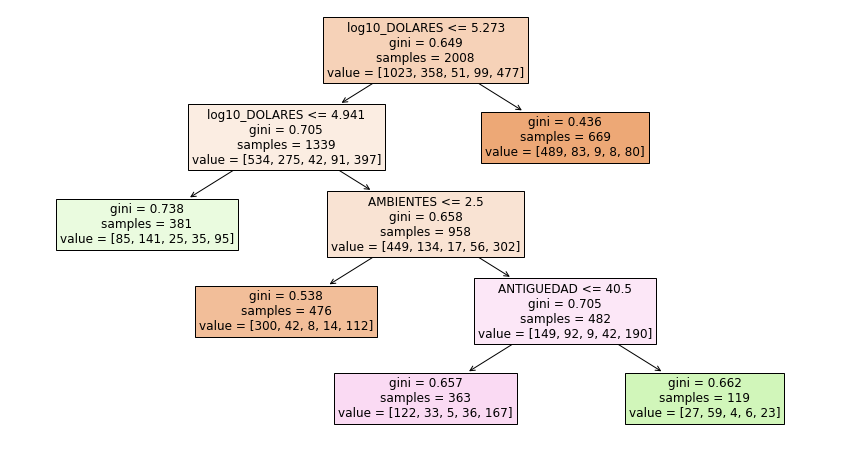

In [ ]:
# Creamos la figura donde plotear el árbol con matplotlib
fig, ax = plt.subplots(figsize = (15, 8))

# Llamamos a la función "plot_tree" que importamos de sklearn.tree más arriba.
# Le pasamos como argumento el modelo que creamos y el nombre de los features.
# "fontsize" y "filled" son solo ajustes de la visualización
# y le decimos que plotee el arbol en la figura que creamos
plot_tree(dtc, feature_names=features, fontsize = 12, filled = True, ax = ax)

Por default, el árbol usa el coeficiente de Gini para separar las clases (ver documentación de scikit-learn y clase teórica). En cada nodo y cada hoja podemos ver la cantidad de instancias dentro, y a qué clase pertenece. Uno de los factores más importantes que usa el árbol para separar es el precio de los inmuebles.

Recordemos que si no especificamos la profundidad del árbol, esta es la máxima posible, lo cual puede llevar a overfittear. Podemos agregarle un término de regularización y tratar de estimarlo con cross-validation:

In [ ]:
# Tomamos un valor de alpha entre 10^-10 y 1. Usamos un barrido logaritmico.
for alpha in np.logspace(-10, 0, 11):

    # Creamos el modelo para un dado valor de alpha
    dtr = DecisionTreeClassifier(ccp_alpha = alpha)

    # Calculamos los scores al hacer cross-validation con 5 folds
    # Al especificar el valor de cv, cross_val_score hace cross-validation estratificado
    scores = cross_val_score(dtr, X_train, y_train, cv = 5)

    # Imprimimos el valor de alpha y el score medio
    print('Valor de alpha {} - Score medio = {}'.format(alpha, scores.mean()))

Valor de alpha 1e-10 - Score medio = 0.6638453617200779
Valor de alpha 1e-09 - Score medio = 0.6743067703874642
Valor de alpha 1e-08 - Score medio = 0.6683279363779605
Valor de alpha 1e-07 - Score medio = 0.6693242019329786
Valor de alpha 1e-06 - Score medio = 0.6708167392464114
Valor de alpha 1e-05 - Score medio = 0.6698204736913934
Valor de alpha 0.0001 - Score medio = 0.6683254550191686
Valor de alpha 0.001 - Score medio = 0.6822768948276077
Valor de alpha 0.01 - Score medio = 0.560754829344549
Valor de alpha 0.1 - Score medio = 0.5094614210741801
Valor de alpha 1.0 - Score medio = 0.5094614210741801


Tomemos el valor de $\alpha$ donde es el score sea máximo y veamos cómo le va a nuestro modelo en el set de testeo:

In [ ]:
alpha = 10**-5

# Creamos el modelo para un dado valor de alpha
dtr = DecisionTreeClassifier(ccp_alpha = alpha)

# Entrenamos el modelo
dtr.fit(X_train, y_train)

# Calculamos el score en el set de testeo
dtr.score(X_test, y_test)

0.7321428571428571

Lo que vemos es que agregarle regularización podemos obtener una performance un poquito más grande, pero no parece ser muy significativa. Vamos a probar luego con otro modelo como Random Forest para ver si mejora.

Igualmente recordemos antes que, como muchos de los clasificadores en scikit-learn, lo que obtenemos con estos es una probabilidad de a qué clase pertenece cada instancia:

In [ ]:
dtr.predict_proba(X_test)

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]])

donde, para identificar las columnas de la matriz anterior, podemos inspeccionar cómo están ordenadas las clases con el atributo *classes_*:

In [ ]:
print(dtr.classes_)

['A' 'B' 'C' 'D' 'E']


Si el problema fuera de clasificación binaria, recordemos que con las probabilidades podemos barrer en umbrales y construir matrices de confusión, realizar la curva ROC y calcular el AUC.

### Random forest para clasificación

Probemos con otro modelo a ver si mejora un poco nuestra predicción, en este caso con un ensamble de 100 árboles de decisión que constituyen nuestro Random Forest.

In [ ]:
# Construcción del clasificador como Random Forest
rfc = RandomForestClassifier(n_estimators=100)

In [ ]:
# Entrenamiento del modelo
rfc.fit(X_train, y_train)

RandomForestClassifier()

Veamos las probabilidades que nos devuelve al algortimo para el set de testeo. Recordemos que este es el resultado de la votación de cada árbol incluído en el bosque (si cada árbol da un probabilidad, entra como un promedio pesado):

In [ ]:
rfc.predict_proba(X_test)

array([[0.92, 0.01, 0.05, 0.  , 0.02],
       [0.95, 0.01, 0.  , 0.  , 0.04],
       [0.07, 0.02, 0.  , 0.01, 0.9 ],
       ...,
       [0.97, 0.  , 0.  , 0.  , 0.03],
       [0.5 , 0.08, 0.  , 0.  , 0.42],
       [0.59, 0.  , 0.01, 0.  , 0.4 ]])

Asignando la clase más probable a cada instancia, podemos comparar con las etiquetas reales:

In [ ]:
# Performance del modelo
rfc.score(X_test, y_test)

0.7544642857142857

Si bien este número puede fluctuar cada vez que corramos esta notebook, la performance del modelo es en general mucho mejor que con un único árbol.
Veamos qué nos dice la lista de features más explicativos:

In [ ]:
# Este atributo tiene una medida de la importancia de cada feature
feature_importance = rfc.feature_importances_

print('Features: {}'.format(features))
print('Importancia = {}'.format(feature_importance))

Features: ['M2', 'AMBIENTES', 'ANTIGUEDAD', 'BAÑOS', 'log10_DOLARES']
Importancia = [0.31027827 0.06328929 0.2046997  0.02988886 0.39184388]


Algo que definitivamente está bien es que las variables "cantidad de ambientes" y "cantidad de baños" no parecen ser muy informativos de la zona (en definitiva, podemos encontrar departamentos con una dada cantidad de ambientes y baños en cualquier parte de la ciudad). A diferencia del problema de regresión donde teníamos un feature muy dominante, las variables $m^2$, antigüedad y precio tienen un peso similar.

## Cosas para llevarse de esta notebook

Podemos constuir los árboles de decisión para clasificación en *scikit-learn* con el siguiente código:
~~~
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier()
~~~
donde podemos indicarle los parámetros:
~~~
max_depth: profundidad del árbol
ccp_alpha: constante de regularización
min_samples_leaf: mínima cantidad de instancias en cada hoja
max_leaf_nodes: máxima cantidad de hojas en el árbol
~~~
notar que estos argumentos compiten entre sí y no pueden fijarse siempre en simultáneo. Para ajustar el modelo es igual a otros modelos:
~~~
dtc.fit(X_train, y_train)
~~~
y para sacar la performance:
~~~
dtc.score(X_test, y_test)
~~~
Si no sabemos la profundidad del árbol se la podemos preguntar así:
~~~
dtc.get_depth()
~~~
Para obtener las probabilidades de que las instancias pertenezcan a una dada clase lo hacemos así:
~~~
dtc.predict_proba(X_test)
~~~

Para Random Forest la sintaxis es muy similar:
~~~
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators = 100)
~~~
donde por default el número de árboles en el ensamble es de 100. La mayoría del resto de los argumentos son los mismos que para los árboles de decisión. Para ver la importancia de cada feature e interpretar un poco el algoritmo podemos verlo así:
~~~
rfc.feature_importance_
~~~

## Cosas para hacer

- ¿Podemos hacer algo mejor con Random Forest? Quizás variar algún que otro parámetro y hacer cross-validation sea una buena idea...
- Una vez que construyamos un buen modelo, es significativamente mejor que un modelo nulo? ¿Cómo lo implementaría?